In [44]:
import IPython
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import re
import seaborn as sns

In [45]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
import scipy as sp
from scipy.stats import ttest_ind_from_stats

In [46]:
raw_data = pd.read_csv('cleaned_data.csv')

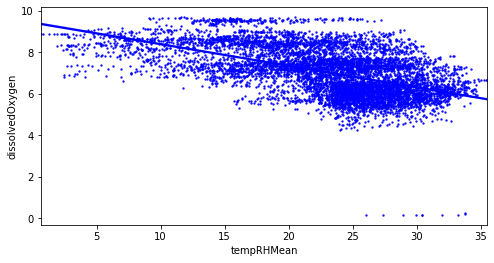

In [47]:
# There are several outliers here.
plt.figure(figsize = (8,4))
ax = sns.regplot(data = raw_data, x='tempRHMean', y='dissolvedOxygen', 
                     marker = 'o', color = 'b', scatter_kws={'s':2})

In [48]:
# outliers - 10 smallest values for dissolvedOxygen. All of them are in June (probably because of some disaster?).
raw_data.sort_values(by='dissolvedOxygen').head(12)

,startDateTime,siteID,dissolvedOxygen,TFPrecipBulk,buoyWindSpeedMean,staPresMean,tempRHMean,uPARMean,PARMean,surfacewaterElevMean,groundwaterTempMean,surfWaterNitrateMean
2802,2019-06-25 13:00:00,BARC,0.170000,0.0,2.370,101.509230,28.9600,196.515000,1074.740,26.96,22.236429,11.050
2803,2019-06-25 14:00:00,BARC,0.170000,0.0,2.990,101.495390,29.9550,293.618333,1399.700,26.96,22.208462,11.050
2800,2019-06-25 11:00:00,BARC,0.170000,0.0,0.550,101.443360,26.0700,39.421667,254.795,26.96,22.235714,11.075
2804,2019-06-25 15:00:00,BARC,0.170000,0.0,3.200,101.518610,30.4270,473.490000,1801.115,26.96,22.235000,11.000
2801,2019-06-25 12:00:00,BARC,0.170000,0.0,1.970,101.511890,27.3375,104.021667,605.905,26.96,22.235714,11.025
2798,2019-06-24 23:00:00,BARC,0.180000,0.0,2.080,101.193500,31.9470,49.406667,238.235,26.97,22.230714,11.050
2799,2019-06-25 00:00:00,BARC,0.180000,0.0,1.180,101.221510,30.4410,4.096667,21.565,26.97,22.230000,11.025
2797,2019-06-24 22:00:00,BARC,0.182500,0.0,2.560,101.189665,33.1925,144.440000,640.560,26.97,22.199231,11.075
2796,2019-06-24 21:00:00,BARC,0.194286,0.0,2.985,101.215005,33.7610,263.265000,1058.755,26.97,22.200000,11.075
2795,2019-06-24 20:00:00,BARC,0.240000,0.0,3.440,101.246845,33.7425,384.921667,1455.225,26.97,22.231429,11.100


In [49]:
# Remove the outliers.
raw_data = raw_data[raw_data['dissolvedOxygen']>4]
raw_data = raw_data.reset_index().drop('index', axis=1)

In [50]:
# Normalization
def normalize(raw_data, columns):
    for i in columns:
        raw_data[i] = (raw_data[i] - np.mean(raw_data[i])) / np.std(raw_data[i])
    return raw_data.head()

In [51]:
normalize(raw_data, ['TFPrecipBulk', 'buoyWindSpeedMean', 'staPresMean','tempRHMean','uPARMean', 'PARMean',
                    'surfacewaterElevMean','groundwaterTempMean','surfWaterNitrateMean'])

,startDateTime,siteID,dissolvedOxygen,TFPrecipBulk,buoyWindSpeedMean,staPresMean,tempRHMean,uPARMean,PARMean,surfacewaterElevMean,groundwaterTempMean,surfWaterNitrateMean
0,2018-05-24 04:00:00,BARC,6.610000,-0.124686,-1.122224,0.648440,0.182454,-0.737448,-0.804174,0.121577,-1.707266,2.002445
1,2018-05-24 05:00:00,BARC,6.716667,-0.124686,-1.233376,0.585255,0.069114,-0.737397,-0.804174,0.121577,-1.702181,2.015470
2,2018-06-11 22:00:00,BARC,6.570000,-0.124686,-0.286357,-0.284319,0.392732,-0.272162,-0.106166,0.351027,-1.399643,2.562534
3,2018-06-12 07:00:00,BARC,6.480000,-0.124686,-1.166685,0.092977,-0.013455,-0.737594,-0.804174,0.351027,-1.376762,2.601610
4,2018-06-13 03:00:00,BARC,6.340000,-0.124686,-1.131116,0.612087,0.138693,-0.737654,-0.804174,0.368677,-1.358966,2.549509


In [52]:
# Turn startdatetime to year/month/date/time
year, month, date, time = [], [], [], []

for i in range(raw_data.shape[0]):
    text = raw_data['startDateTime'][i]
    pattern = r"([0-9]{4})-([0-9]{2})-([0-9]{2}) ([0-9]+):"
    clock = re.findall(pattern, text)[0]
    year.append(clock[0])
    month.append(clock[1])
    date.append(clock[2])
    time.append(clock[3])

n = raw_data.drop('startDateTime', axis = 1)
new_data = pd.DataFrame({'year':year, 'month':month, 'date':date, "time":time})
new_data = pd.concat([new_data, n], axis = 1)
new_data = new_data.drop('siteID', axis = 1)

In [53]:
new_data_year = new_data.groupby('year').mean()
new_data_month = new_data.groupby('month').mean()
new_data_date = new_data.groupby('date').mean()
new_data_time = new_data.groupby('time').mean()

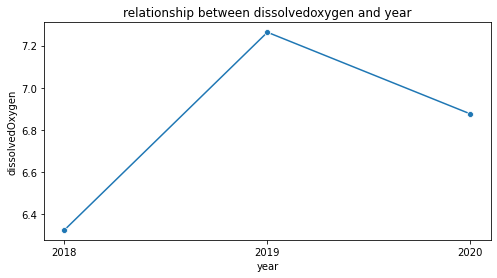

In [54]:
plt.figure(figsize = (8,4))
ax = sns.lineplot(data = new_data_year, x='year', y='dissolvedOxygen', marker = 'o')
ax.set_title('relationship between dissolvedoxygen and year');

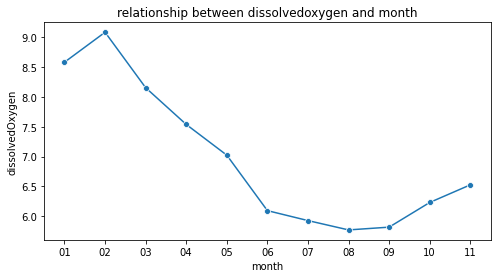

In [55]:
plt.figure(figsize = (8,4))
ax = sns.lineplot(data = new_data_month, x='month', y='dissolvedOxygen', marker = 'o')
ax.set_title('relationship between dissolvedoxygen and month');

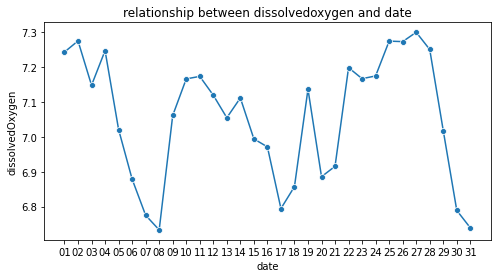

In [56]:
plt.figure(figsize = (8,4))
ax = sns.lineplot(data = new_data_date, x='date', y='dissolvedOxygen', marker = 'o')
ax.set_title('relationship between dissolvedoxygen and date');

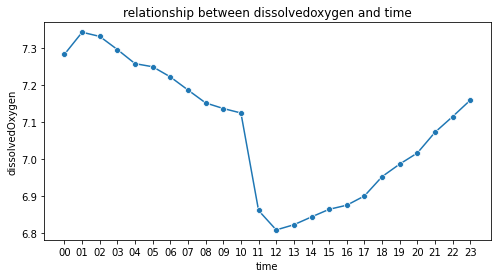

In [57]:
plt.figure(figsize = (8,4))
ax = sns.lineplot(data = new_data_time, x='time', y='dissolvedOxygen', marker = 'o')
ax.set_title('relationship between dissolvedoxygen and time');

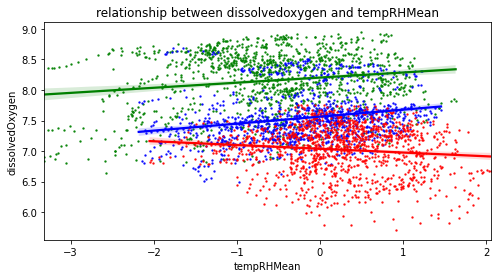

In [58]:
plt.figure(figsize = (8,4))
ax = sns.regplot(data = new_data[new_data['month'] == '03'], x='tempRHMean', y='dissolvedOxygen', 
                     marker = 'o', color = 'g', scatter_kws={'s':2})
ax = sns.regplot(data = new_data[new_data['month'] == '04'], x='tempRHMean', y='dissolvedOxygen', 
                     marker = 'o', color = 'b', scatter_kws={'s':2})
ax = sns.regplot(data = new_data[new_data['month'] == '05'], x='tempRHMean', y='dissolvedOxygen', 
                     marker = 'o', color = 'r', scatter_kws={'s':2})

ax.set_title('relationship between dissolvedoxygen and tempRHMean');

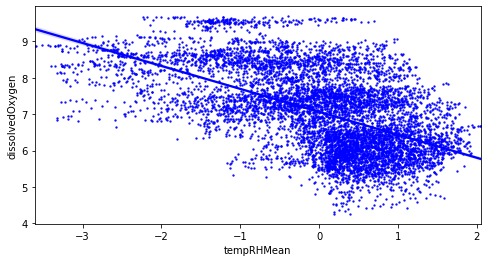

In [59]:
plt.figure(figsize = (8,4))
ax = sns.regplot(data = new_data, x='tempRHMean', y='dissolvedOxygen', 
                     marker = 'o', color = 'b', scatter_kws={'s':2})

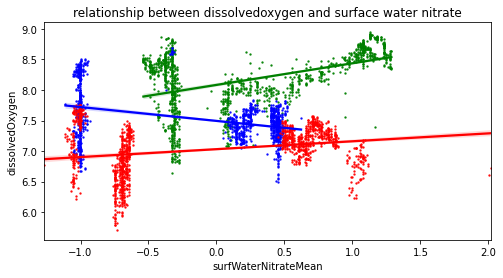

In [60]:
plt.figure(figsize = (8,4))
ax = sns.regplot(data = new_data[new_data['month'] == '03'], x='surfWaterNitrateMean', y='dissolvedOxygen', 
                     marker = 'o', color = 'g', scatter_kws={'s':2})
ax = sns.regplot(data = new_data[new_data['month'] == '04'], x='surfWaterNitrateMean', y='dissolvedOxygen', 
                     marker = 'o', color = 'b', scatter_kws={'s':2})
ax = sns.regplot(data = new_data[new_data['month'] == '05'], x='surfWaterNitrateMean', y='dissolvedOxygen', 
                     marker = 'o', color = 'r', scatter_kws={'s':2})
#ax.set(xscale="log", yscale="log")
ax.set_title('relationship between dissolvedoxygen and surface water nitrate');

In [61]:
def rmse(actual_y, predicted_y):
    return (sum((actual_y - predicted_y) ** 2) / len(actual_y))**0.5

from sklearn.model_selection import KFold
def compute_CV_error(model, X_train, Y_train):
    kf = KFold(n_splits=5)
    validation_errors = []
    
    for train_idx, valid_idx in kf.split(X_train):
        split_X_train, split_X_valid = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        split_Y_train, split_Y_valid = Y_train.iloc[train_idx], Y_train.iloc[valid_idx]
        
        # Fit the model on the training split
        model.fit(split_X_train, split_Y_train)
        
        # Compute the RMSE on the validation split
        error = rmse(split_Y_valid, model.predict(split_X_valid))
        validation_errors.append(error)
    return np.mean(validation_errors)

### Multiple Linear Regression

In [62]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(new_data, test_size=0.2, random_state=42)

In [63]:
# I remove the feature 'TFPrecipBulk', because it made the accuracy lower.

In [64]:
model_MLR = smf.ols(formula = "dissolvedOxygen ~ date + month + groundwaterTempMean + uPARMean + PARMean + tempRHMean + buoyWindSpeedMean + staPresMean + surfacewaterElevMean + surfWaterNitrateMean", 
                data = train_data, missing = 'drop')
model_MLR = model_MLR.fit()
print(model_MLR.summary())

                            OLS Regression Results                            
Dep. Variable:        dissolvedOxygen   R-squared:                       0.886
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     994.6
Date:                Thu, 18 Feb 2021   Prob (F-statistic):               0.00
Time:                        14:48:58   Log-Likelihood:                -2807.6
No. Observations:                6180   AIC:                             5713.
Df Residuals:                    6131   BIC:                             6043.
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                9.3025 

In [65]:
X_train = train_data.drop(['year', 'dissolvedOxygen'], axis = 1)
Y_train = train_data['dissolvedOxygen']

X_test = test_data.drop(['year', 'dissolvedOxygen'], axis = 1)
Y_test = test_data['dissolvedOxygen']

predicted_Y_test = model_MLR.predict(X_test)
predicted_Y_train = model_MLR.predict(X_train)

In [66]:
rmse(Y_train, predicted_Y_train), rmse(Y_test, predicted_Y_test)

(0.3811248694184883, 0.3839458623767203)

In [67]:
try_new = pd.DataFrame({'Y_test': Y_test, 'predicted_Y_test': predicted_Y_test})
try_new.head()

,Y_test,predicted_Y_test
5586,7.540833,6.981042
2184,6.549167,6.737734
3698,6.066667,5.943203
6652,5.862500,5.985067
4727,7.590833,7.712856


### Multiple Linear Regression (Difference in difference)

In [68]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(new_data, test_size=0.2, random_state=42)

In [69]:
model_MLR = smf.ols(formula = "dissolvedOxygen ~ date * (month + groundwaterTempMean + uPARMean + PARMean + tempRHMean + buoyWindSpeedMean + staPresMean + surfacewaterElevMean + surfWaterNitrateMean)", 
                data = train_data, missing = 'drop')
model_MLR = model_MLR.fit()
print(model_MLR.summary())

                            OLS Regression Results                            
Dep. Variable:        dissolvedOxygen   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     446.3
Date:                Thu, 18 Feb 2021   Prob (F-statistic):               0.00
Time:                        14:49:03   Log-Likelihood:                 2064.9
No. Observations:                6180   AIC:                            -3076.
Df Residuals:                    5653   BIC:                             470.4
Df Model:                         526                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

In [70]:
X_train = train_data.drop(['dissolvedOxygen'], axis = 1)
Y_train = train_data['dissolvedOxygen']

X_test = test_data.drop(['dissolvedOxygen'], axis = 1)
Y_test = test_data['dissolvedOxygen']

predicted_Y_test = model_MLR.predict(X_test)
predicted_Y_train = model_MLR.predict(X_train)

In [71]:
rmse(Y_train, predicted_Y_train), rmse(Y_test, predicted_Y_test)

(0.17324173319138794, 0.2071432530374382)

In [72]:
try_new = pd.DataFrame({'Y_test': Y_test, 'predicted_Y_test': predicted_Y_test, 'difference': abs(predicted_Y_test-Y_test)})
try_new.sort_values(by='difference', ascending = False)

,Y_test,predicted_Y_test,difference
3328,5.504286,3.091956,2.412330
4004,8.607273,7.233705,1.373568
4002,8.720000,7.424303,1.295697
1400,8.505833,7.288757,1.217077
7289,5.266667,4.173860,1.092807
...,...,...,...
6850,5.605833,5.605123,0.000710
6683,5.815000,5.814477,0.000523
743,8.698333,8.697921,0.000412
2764,6.946667,6.946946,0.000279


### Random Forest

In [73]:
# Change year/month/date to dummy variables.
def rearrange(df, column_name):
    all_types = df[column_name].unique()
    lst = []
    
    for i in range(len(all_types)):
        # i = 0
        lst.append([])
        # lst = [[]]
        for j in df[column_name]:
            if j == all_types[i]:
                lst[i] += [1]
            else:
                lst[i] += [0]
    df_new = pd.DataFrame([lst[i] for i in range(len(lst))]).transpose()
    df_new = df_new.set_axis(all_types, axis=1)

    return df_new

In [74]:
new_year = rearrange(new_data, 'year').add_suffix('_y')
new_month = rearrange(new_data, 'month').add_suffix('_m')
new_date = rearrange(new_data, 'date').add_suffix('_d')

try_new = pd.concat([new_data, new_year, new_month, new_date], axis=1).drop(['year', 'month', 'date', 'time'], axis=1)
try_new.head()

,dissolvedOxygen,TFPrecipBulk,buoyWindSpeedMean,staPresMean,tempRHMean,uPARMean,PARMean,surfacewaterElevMean,groundwaterTempMean,surfWaterNitrateMean,...,30_d,31_d,01_d,02_d,03_d,04_d,05_d,06_d,07_d,16_d
0,6.610000,-0.124686,-1.122224,0.648440,0.182454,-0.737448,-0.804174,0.121577,-1.707266,2.002445,...,0,0,0,0,0,0,0,0,0,0
1,6.716667,-0.124686,-1.233376,0.585255,0.069114,-0.737397,-0.804174,0.121577,-1.702181,2.015470,...,0,0,0,0,0,0,0,0,0,0
2,6.570000,-0.124686,-0.286357,-0.284319,0.392732,-0.272162,-0.106166,0.351027,-1.399643,2.562534,...,0,0,0,0,0,0,0,0,0,0
3,6.480000,-0.124686,-1.166685,0.092977,-0.013455,-0.737594,-0.804174,0.351027,-1.376762,2.601610,...,0,0,0,0,0,0,0,0,0,0
4,6.340000,-0.124686,-1.131116,0.612087,0.138693,-0.737654,-0.804174,0.368677,-1.358966,2.549509,...,0,0,0,0,0,0,0,0,0,0


In [75]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(try_new, test_size=0.2, random_state=42)

In [76]:
X_train = train_data.drop(['dissolvedOxygen'], axis = 1)
Y_train = train_data['dissolvedOxygen']

X_test = test_data.drop(['dissolvedOxygen'], axis = 1)
Y_test = test_data['dissolvedOxygen']

In [77]:
#max_depth, loop the max depth to see where is the maximum accuracy
#max_features: sqrt=auto>log2, criterion: gini>entropy
from sklearn.ensemble import RandomForestRegressor

model2 = RandomForestRegressor(n_estimators=100,random_state=42,bootstrap = True)
model2.fit(X_train, Y_train)

predicted_Y_train = model2.predict(X_train)

# Accuracy of model - training data
model2_accuracy = model2.score(X_train,Y_train)
display(model2_accuracy)

# Accuracy of model - test data
predicted_Y_test = model2.predict(X_test)
model2_test_accuracy = model2.score(X_test, Y_test)
display(model2_test_accuracy)

0.9981943881437961

0.9898480444974506

In [78]:
#Root mean square error of training data and test data.
rmse(Y_train, predicted_Y_train), rmse(Y_test, predicted_Y_test)

(0.04800652565824099, 0.11555933667758415)

#### Most important features - random forest

In [79]:
X_select = try_new.drop(['dissolvedOxygen'], axis = 1)
Y_select = try_new['dissolvedOxygen']

In [80]:
import matplotlib.pyplot as plt
model2.fit(X_select,Y_select)
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model2.feature_importances_, index=X_select.columns)
feat_importances

TFPrecipBulk            3.498666e-04
buoyWindSpeedMean       2.610517e-03
staPresMean             1.056582e-02
tempRHMean              3.156932e-01
uPARMean                2.781969e-03
PARMean                 5.018572e-03
surfacewaterElevMean    1.290383e-01
groundwaterTempMean     1.755577e-01
surfWaterNitrateMean    4.097149e-02
2018_y                  1.607081e-05
2019_y                  2.061219e-04
2020_y                  1.003200e-03
05_m                    4.360478e-02
06_m                    8.897747e-03
07_m                    1.082948e-02
01_m                    6.316630e-03
02_m                    7.807130e-02
03_m                    1.021217e-01
04_m                    5.414931e-02
08_m                    5.994167e-04
09_m                    1.779198e-04
10_m                    3.950966e-05
11_m                    2.118545e-07
24_d                    8.584140e-04
11_d                    2.610463e-04
12_d                    1.795492e-04
13_d                    3.137074e-04
1

In [81]:
importance = feat_importances.nlargest(20)
importance

tempRHMean              0.315693
groundwaterTempMean     0.175558
surfacewaterElevMean    0.129038
03_m                    0.102122
02_m                    0.078071
04_m                    0.054149
05_m                    0.043605
surfWaterNitrateMean    0.040971
07_m                    0.010829
staPresMean             0.010566
06_m                    0.008898
01_m                    0.006317
PARMean                 0.005019
uPARMean                0.002782
buoyWindSpeedMean       0.002611
2020_y                  0.001003
20_d                    0.000994
08_d                    0.000946
24_d                    0.000858
25_d                    0.000778
dtype: float64

In [82]:
col = list(importance.index)
col.append('dissolvedOxygen')

try_new_importances = try_new[col]

In [83]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(try_new_importances, test_size=0.2, random_state=42)

In [84]:
X_train = train_data.drop(['dissolvedOxygen'], axis = 1)
Y_train = train_data['dissolvedOxygen']

X_test = test_data.drop(['dissolvedOxygen'], axis = 1)
Y_test = test_data['dissolvedOxygen']

In [85]:
#max_depth, loop the max depth to see where is the maximum accuracy
#max_features: sqrt=auto>log2, criterion: gini>entropy
from sklearn.ensemble import RandomForestRegressor

model3 = RandomForestRegressor(n_estimators=100,random_state=42,bootstrap = True)
model3.fit(X_train, Y_train)

predicted_Y_train = model3.predict(X_train)

model3_accuracy = model3.score(X_train,Y_train)
display(model3_accuracy)

predicted_Y_test = model3.predict(X_test)
model3_test_accuracy = model3.score(X_test, Y_test)
display(model3_test_accuracy)

0.9979972373912385

0.9885743464408504

In [86]:
rmse(Y_train, predicted_Y_train), rmse(Y_test, predicted_Y_test)

(0.05055950514770423, 0.12259442281902386)